# Note: This notebook runs using Google Colab.

Link to data to run this notebook:
https://drive.google.com/open?id=1iwaXc_AqhyUhee2R_C7wSyeIRlRNpWH0

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Preprocessing

In [0]:
import pandas as pd
import numpy as np
import math
import csv


In [3]:
data_all = pd.read_csv('gdrive/My Drive/instacart_combined_data.csv')
data_all.head()

,user_id,order_number,add_to_cart_order,order_id,eval_set,order_dow,order_hour_of_day,days_since_prior_order,product_id,reordered,product_name,aisle_id,department_id,aisle,department
0,1,1,1,2539329,prior,2,8,NaN,196,0,Soda,77,7,soft drinks,beverages
1,1,1,2,2539329,prior,2,8,NaN,14084,0,Organic Unsweetened Vanilla Almond Milk,91,16,soy lactosefree,dairy eggs
2,1,1,3,2539329,prior,2,8,NaN,12427,0,Original Beef Jerky,23,19,popcorn jerky,snacks
3,1,1,4,2539329,prior,2,8,NaN,26088,0,Aged White Cheddar Popcorn,23,19,popcorn jerky,snacks
4,1,1,5,2539329,prior,2,8,NaN,26405,0,XL Pick-A-Size Paper Towel Rolls,54,17,paper goods,household


In [0]:
#data_all.count()

## Model for customer segmentation using aisle

In [5]:
# create cross-tabl user_id aisle_id for customer segmentation.
cust_prod = pd.crosstab(data_all['user_id'], data_all['aisle'])
cust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,4,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,...,0,0,0,0,0,3,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,2
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,13,0,0,0,0,5,0,11,0,1,0,0,0,0,0,...,0,1,0,0,3,0,0,1,0,11,0,0,2,0,0,0,5,0,0,0,0,0,0,0,3,2,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,...,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,1,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [0]:
#cust_prod.shape

Normalizind cust_prod dataframe by dividing the count for each customer by the number of the orders the customer has. This way, the total number of orders and the total number of items is scaled.

In [7]:
cust_order = data_all.groupby('user_id')['order_number'].max()
cust_prod = cust_prod.div(cust_order, axis=0)
cust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.000000,0.0,0.363636,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.272727,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.272727,0.0,0.000000,0.0,1.181818,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.363636,0.0,0.181818,0.0,0.0,0.0,0.0,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.181818
2,0.0,0.2,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.066667,0.066667,0.133333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.000000,0.866667,0.0,0.0,0.0,0.0,0.333333,0.0,0.733333,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.066667,0.0,0.0,0.200000,0.000000,0.0,0.066667,0.0,0.733333,0.0,0.000000,0.133333,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.2,0.133333,0.0,0.0,0.0,0.0,0.200000,0.066667,0.066667,0.0,0.0,0.0,0.0,0.133333,0.0,2.800000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,1.166667,0.083333,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.250000,0.0,0.0,0.0,0.0,0.333333,0.083333,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.2,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.2,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.2,0.000000,0.0,0.2,0.0,0.0,0.000000,0.000000,0.000000,0.2,0.0,0.0,0.0,0.200000,0.0,0.000000
5,0.2,0.8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.2,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,2.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.600000


### Model 1 - customers ordered products only

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1
0,-1.362204,0.065982
1,0.336303,2.827393
2,-0.112264,0.498274
3,-1.460849,-0.145432
4,0.615222,-0.063101


(206209, 2)
          0         1
0 -1.362204  0.065982
1  0.336303  2.827393
2 -0.112264  0.498274
3 -1.460849 -0.145432
4  0.615222 -0.063101


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


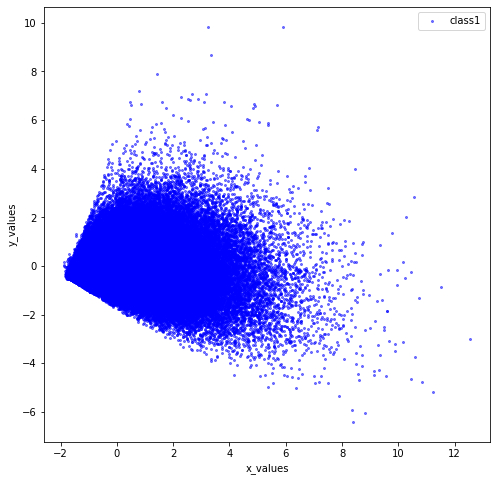

In [9]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[0,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[0], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

What number of clusters should we have?

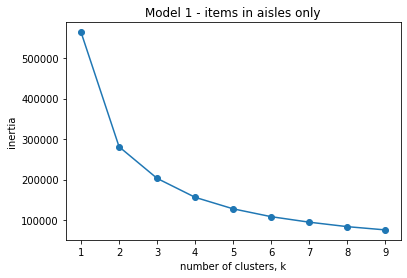

In [10]:
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tocluster)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.title('Model 1 - items in aisles only')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Based on the graph above, we may have 2 clusters only.

In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=2,random_state=55).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.74716187  0.00223385]
 [ 1.83636992 -0.00549034]]


Cluster appearance

['orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange', 'blue', 'orange', 'blue']


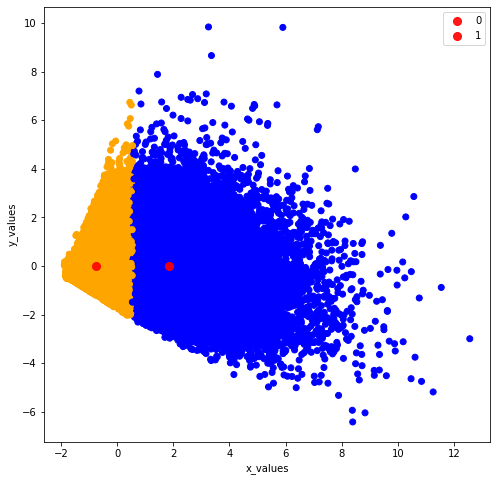

In [12]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

Possible clustering below.

In [13]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

clust_prod.head(10)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.181818,0.000000,0.000000,0.000000,0.000000,0.0,0.363636,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.272727,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.272727,0.0,0.000000,0.0,1.181818,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,1.363636,0.000000,0.181818,0.0,0.0,0.000000,0.0,0.090909,0.000000,0.000000,0.00,0.0,0.0,0.0,0.000000,0.0,0.181818,0
2,0.0,0.200000,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.066667,0.066667,0.133333,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.066667,0.0,0.000000,0.866667,0.0,0.0,0.000000,0.0,0.333333,0.0,0.733333,0.000000,0.066667,0.0,0.0,0.0,0.000000,0.0,...,0.066667,0.000000,0.000000,0.200000,0.000000,0.0,0.066667,0.0,0.733333,0.000000,0.000000,0.133333,0.0,0.0,0.0,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.200000,0.133333,0.0,0.0,0.000000,0.0,0.200000,0.066667,0.066667,0.00,0.0,0.0,0.0,0.133333,0.0,2.800000,0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,1.166667,0.083333,0.0,0.000000,0.0,0.000000,0.000000,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,1.250000,0.0,0.0,0.000000,0.0,0.333333,0.083333,0.000000,0.00,0.0,0.0,0.0,0.166667,0.0,0.000000,0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.200000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.200000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.2,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.2,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.2,0.200000,0.0,0.000000,0.0,0.0,0.0,0.0,0.200000,0.200000,0.000000,0.0,0.2,0.000000,0.0,0.000000,0.000000,0.000000,0.20,0.0,0.0,0.0,0.200000,0.0,0.000000,0
5,0.2,0.800000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.0,0.000000,0.200000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.000000,2.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0

In [0]:

#f,arr = plt.subplots(1,2,sharex=True,figsize=(15,8))

#c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
#arr[0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
#arr[1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)


#plt.show()

Top ten of each cluster

In [15]:
c0.sort_values(ascending=False)[0:10]

aisle
fresh fruits                     0.648087
fresh vegetables                 0.480574
packaged vegetables fruits       0.345303
yogurt                           0.315428
water seltzer sparkling water    0.255307
packaged cheese                  0.235558
chips pretzels                   0.208784
milk                             0.208271
ice cream ice                    0.158933
refrigerated                     0.153827
dtype: float64

In [16]:
c1.sort_values(ascending=False)[0:10]

aisle
fresh vegetables              2.462857
fresh fruits                  2.014144
packaged vegetables fruits    0.998332
yogurt                        0.665516
packaged cheese               0.468060
milk                          0.332728
soy lactosefree               0.293644
frozen produce                0.281258
chips pretzels                0.271657
fresh herbs                   0.254273
dtype: float64

On average, the customers in cluster 1 order more of each product in a single basked than the customers in cluster 0. There are almost 2.5 items per order of fresh vegetables and only 0.65 per customer in cluster 1. Same with fresh fruits - 2 vs 0.48.

We can extend beyond the first ten by exploring items 10 to 15.

In [17]:
print('cluster 0')
print(c0.sort_values(ascending=False)[10:15])
print('cluster 1')
print(c1.sort_values(ascending=False)[10:15])

cluster 0
aisle
bread              0.147141
soy lactosefree    0.145287
frozen meals       0.139402
soft drinks        0.138905
crackers           0.123634
dtype: float64
cluster 1
aisle
water seltzer sparkling water    0.252431
bread                            0.247412
eggs                             0.218456
refrigerated                     0.214347
crackers                         0.185192
dtype: float64


The items in this part of the basket are different, with exception of the bread. The second group of customers ordered less of each product on average. 

 The fact that the first 10 match almost exactly is that these items are always ordered.

 Cluster 0 below has on average less than 8 items. Cluster 1 about doubles that size.

 In Cluster 0, we have 3/7.8 - about 38% of items are the ten most ordered items. In cluster 1 - the percent is more than half: 8/15.3 = 52%.

In [18]:
print('Cluster 0 average size: ', c0.sum())
print('Cluster 0 first ten items part: ', c0.sort_values(ascending=False)[:10].sum())
print('Cluster 1 average size: ', c1.sum())
print('Cluster 1 first ten items part: ', c1.sort_values(ascending=False)[:10].sum())

Cluster 0 average size:  7.815401890533697
Cluster 0 first ten items part:  3.010072415455757
Cluster 1 average size:  15.309128672671719
Cluster 1 first ten items part:  8.042468298435493


### Model 1a - more dimensions

Using the same data above, we can check how the model changes if we use 3 or 4 dimension PCA.

In [19]:
# three dimensions
pca3 = PCA(n_components=3)
pca3.fit(cust_prod)
pca_samples3 = pca3.transform(cust_prod)
ps3 = pd.DataFrame(pca_samples3)
ps3.head()

,0,1,2
0,-1.362204,0.065982,-0.032427
1,0.336303,2.827393,0.775711
2,-0.112264,0.498274,-0.827627
3,-1.460849,-0.145432,-0.239262
4,0.615222,-0.063101,0.099493


(206209, 3)
          0         1         2
0 -1.362204  0.065982 -0.032427
1  0.336303  2.827393  0.775711
2 -0.112264  0.498274 -0.827627
3 -1.460849 -0.145432 -0.239262
4  0.615222 -0.063101  0.099493


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


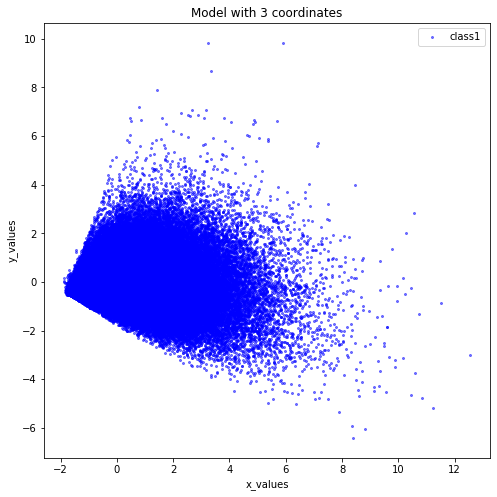

In [20]:
# preparation
tocluster = pd.DataFrame(ps3[[0, 1, 2]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[0], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.title('Model with 3 coordinates')
plt.legend()
plt.show()

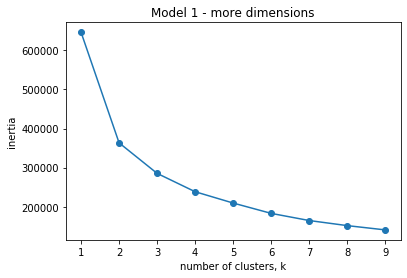

In [21]:
# inertia 3 dimensional PCA
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tocluster)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.title('Model 1 - more dimensions')
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Adding another dimension to the clustering does not change the inertia. The model that may be considered best still has 2 clusters. We will add one more dimension and try again.

In [22]:
# is model the same?
print (clust_prod.shape)
#f,arr = plt.subplots(1,2,sharex=True,figsize=(15,8))

#c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
#arr[0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
#arr[1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)


#plt.show()

(206209, 135)


In [23]:
# four dimension PCA.
pca4 = PCA(n_components=4)
pca4.fit(cust_prod)
pca_samples4 = pca4.transform(cust_prod)
ps4 = pd.DataFrame(pca_samples4)
ps4.head()

,0,1,2,3
0,-1.362204,0.065982,-0.032425,-0.072217
1,0.336303,2.827393,0.775701,0.660921
2,-0.112264,0.498274,-0.827620,-0.234545
3,-1.460849,-0.145432,-0.239267,-0.024638
4,0.615222,-0.063101,0.099493,0.010432


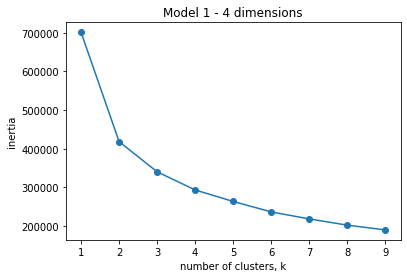

In [24]:
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(ps4)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.title('Model 1 - 4 dimensions')
plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

### Model 2 - using averages and number of items in basket

We use the same cust_prod dataframe. This time, we add variables associated with averages. We use day and time of order, max number of orders and average items in order.

In [0]:
# variability of data
data_first = data_all[data_all.add_to_cart_order == 1]
user_var = pd.DataFrame()

user_var['average_dow'] = data_first.groupby('user_id')['order_dow'].mean()
user_var['average_hour'] = data_first.groupby('user_id')['order_hour_of_day'].mean()
user_var['average_days_since'] = data_first.groupby('user_id')['days_since_prior_order'].mean()
user_var['max_days_between_orders'] = data_first.groupby('user_id')['days_since_prior_order'].max()

user_var['max_items'] = data_all.groupby('user_id')['add_to_cart_order'].max()
total_items = data_all.groupby('user_id')['add_to_cart_order'].count()
user_var['average_items_in_order'] = total_items.div(cust_order, axis=0)

data_ml = pd.merge(left=cust_prod, right=user_var, left_index=True, right_index=True)

### Dimension reduction

In [0]:
from sklearn.decomposition import PCA

In [27]:
pca = PCA(n_components=2)
pca.fit(data_ml)
pca_samples = pca.transform(data_ml)
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1
0,-8.557325,-3.562519
1,13.439141,-4.663113
2,-6.482444,7.141525
3,-12.056765,6.850030
4,-4.511389,8.547908


Shape of data Model 2

(206209, 2)
           0         1
0  -8.557325 -3.562519
1  13.439141 -4.663113
2  -6.482444  7.141525
3 -12.056765  6.850030
4  -4.511389  8.547908


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


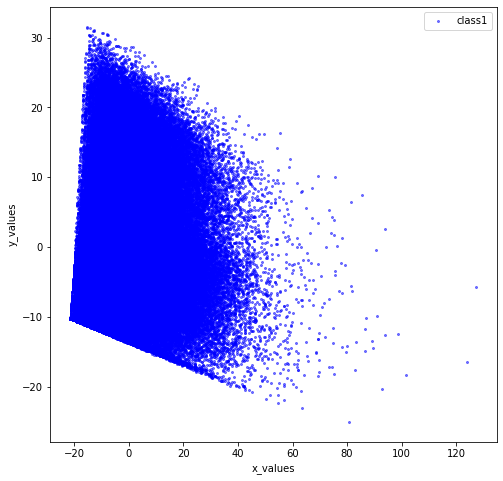

In [28]:
tocluster = pd.DataFrame(ps[[0,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[0], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

What would be the best number of clusters?

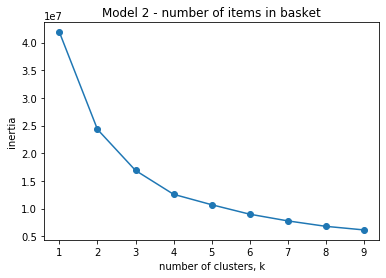

In [29]:
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tocluster)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.title('Model 2 - number of items in basket')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

Based on the inertia graph, we can choose to have 4 clusters.

In [30]:
clusterer = KMeans(n_clusters=4,random_state=55).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-10.23248523  -3.08741918]
 [  3.55772903  -3.45531791]
 [ 21.54655982  -1.07494377]
 [ -1.4096494   13.27014527]]


Cluster appearance

['orange', 'purple', 'green', 'orange', 'green', 'green', 'blue', 'blue', 'purple', 'purple']


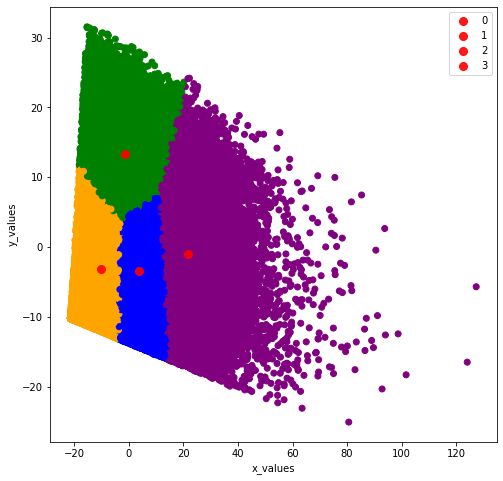

In [31]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [0]:
clust_prod['cluster'] = c_preds
#f,arr = plt.subplots(2,2,sharex=True,figsize=(15,8))

#c1_count = len(clust_prod[clust_prod['cluster']==0])

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
#arr[0, 0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c0)

c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
#arr[0, 1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c1)

c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()
#arr[1,0].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c2)

c3 = clust_prod[clust_prod['cluster']==3].drop('cluster',axis=1).mean()
#arr[1,1].bar(range(len(clust_prod.drop('cluster',axis=1).columns)),c3)
#plt.show()

Ten most bought items in each cluster

In [33]:
c0.sort_values(ascending=False)[0:15]

aisle
fresh fruits                     0.551040
fresh vegetables                 0.468563
packaged vegetables fruits       0.271392
water seltzer sparkling water    0.204346
yogurt                           0.187258
milk                             0.148617
packaged cheese                  0.144934
packaged produce                 0.141122
chips pretzels                   0.125387
ice cream ice                    0.108429
soy lactosefree                  0.107396
soft drinks                      0.104968
refrigerated                     0.096877
bread                            0.093507
frozen produce                   0.086489
dtype: float64

In [34]:
c1.sort_values(ascending=False)[0:15]

aisle
fresh vegetables                 1.393585
fresh fruits                     1.252642
packaged vegetables fruits       0.662812
yogurt                           0.514296
packaged cheese                  0.374205
milk                             0.276552
water seltzer sparkling water    0.270603
chips pretzels                   0.266254
soy lactosefree                  0.230188
bread                            0.213827
frozen produce                   0.208658
refrigerated                     0.200341
ice cream ice                    0.194137
eggs                             0.183512
frozen meals                     0.178016
dtype: float64

In [35]:
c2.sort_values(ascending=False)[0:15]

aisle
fresh vegetables                 2.119698
fresh fruits                     1.997348
packaged vegetables fruits       1.053878
yogurt                           0.908825
packaged cheese                  0.672385
chips pretzels                   0.481361
milk                             0.440531
water seltzer sparkling water    0.377591
bread                            0.356345
soy lactosefree                  0.335294
frozen produce                   0.333845
refrigerated                     0.333638
baby food formula                0.322187
crackers                         0.320757
energy granola bars              0.306834
dtype: float64

In [36]:
c3.sort_values(ascending=False)[0:15]

aisle
fresh fruits                     0.970997
fresh vegetables                 0.854190
packaged vegetables fruits       0.457796
yogurt                           0.348712
water seltzer sparkling water    0.237742
milk                             0.237531
packaged cheese                  0.226145
chips pretzels                   0.177670
soy lactosefree                  0.169346
refrigerated                     0.152171
bread                            0.144944
ice cream ice                    0.136450
frozen produce                   0.133110
eggs                             0.117031
soft drinks                      0.112370
dtype: float64

In [37]:
print('Average number of items in cluster 0: ', c0.sum())
print('Average number of items in cluster 1: ', c1.sum())
print('Average number of items in cluster 2: ', c2.sum())
print('Average number of items in cluster 3: ', c3.sum())

Average number of items in cluster 0:  5.515272959274219
Average number of items in cluster 1:  11.987611965032334
Average number of items in cluster 2:  19.785571428675247
Average number of items in cluster 3:  8.314230120738044


We check the items 10 - 20 for all four clusters.

In [38]:
print('Cluster 0')
print(c0.sort_values(ascending=False)[10:20])
print('Cluster 1')
print(c1.sort_values(ascending=False)[10:20])
print('Cluster 2')
print(c2.sort_values(ascending=False)[10:20])
print('Cluster 3')
print(c3.sort_values(ascending=False)[10:20])

Cluster 0
aisle
soy lactosefree    0.107396
soft drinks        0.104968
refrigerated       0.096877
bread              0.093507
frozen produce     0.086489
eggs               0.080948
crackers           0.073310
frozen meals       0.072004
cereal             0.068326
juice nectars      0.065600
dtype: float64
Cluster 1
aisle
frozen produce         0.208658
refrigerated           0.200341
ice cream ice          0.194137
eggs                   0.183512
frozen meals           0.178016
crackers               0.166286
soup broth bouillon    0.154678
fresh herbs            0.153451
lunch meat             0.153020
energy granola bars    0.148402
dtype: float64
Cluster 2
aisle
frozen produce         0.333845
refrigerated           0.333638
baby food formula      0.322187
crackers               0.320757
energy granola bars    0.306834
ice cream ice          0.284797
frozen meals           0.282305
lunch meat             0.274224
cereal                 0.254187
soup broth bouillon    0.246287
dt

Data time parameters

In [0]:
user_var['cluster'] = c_preds
#f,arr = plt.subplots(2,2,sharex=True,figsize=(15,8))



v0 = user_var[user_var['cluster']==0].drop('cluster',axis=1).mean()
#arr[0, 0].bar(range(len(user_var.drop('cluster',axis=1).columns)),v0)

v1 = user_var[user_var['cluster']==1].drop('cluster',axis=1).mean()
#arr[0, 1].bar(range(len(user_var.drop('cluster',axis=1).columns)),v1)

v2 = user_var[user_var['cluster']==2].drop('cluster',axis=1).mean()
#arr[1,0].bar(range(len(user_var.drop('cluster',axis=1).columns)),v2)

v3 = user_var[user_var['cluster']==3].drop('cluster',axis=1).mean()
#arr[1,1].bar(range(len(user_var.drop('cluster',axis=1).columns)),v3)
#plt.show()

The key parameter that divides clusters is the number of items in the basket. The average number of items in cluster 0 is 5.5, a little more than the mode of the items in the whole dataset - 5. The second cluster has 8.3 items in it, third - about 12, and last - about 20 items.

Which are the common items in the 4 clusters between the fifteen most bought items?

In [0]:
c0last = c0.sort_values(ascending=False).reset_index()
c1last = c1.sort_values(ascending=False).reset_index()
c2last = c2.sort_values(ascending=False).reset_index()
c3last = c3.sort_values(ascending=False).reset_index()

elem_0f = set(c0last.iloc[:15]['aisle'])
elem_1f = set(c1last.iloc[:15]['aisle'])
elem_2f = set(c2last.iloc[:15]['aisle'])
elem_3f = set(c3last.iloc[:15]['aisle'])

elem_0 = set(c0last[c0last[0]<0.005]['aisle'])
elem_1 = set(c1last[c1last[0]<0.005]['aisle'])
elem_2 = set(c2last[c2last[0]<0.005]['aisle'])
elem_3 = set(c3last[c3last[0]<0.005]['aisle'])


In [41]:
common_elem = elem_0f & elem_1f & elem_2f & elem_3f
common_elem

{'bread',
 'chips pretzels',
 'fresh fruits',
 'fresh vegetables',
 'frozen produce',
 'milk',
 'packaged cheese',
 'packaged vegetables fruits',
 'refrigerated',
 'soy lactosefree',
 'water seltzer sparkling water',
 'yogurt'}

In [42]:
# compare the clusters first 15 items
list_common = list(common_elem)

top_15 = pd.concat([c0.loc[(name for name in list_common)], c1.loc[(
    name for name in list_common)], c2.loc[(name for name in list_common)], c3.loc[(
    name for name in list_common)]],axis=1)
top_15

,0,1,2,3
aisle,,,,
chips pretzels,0.125387,0.266254,0.481361,0.177670
fresh fruits,0.551040,1.252642,1.997348,0.970997
fresh vegetables,0.468563,1.393585,2.119698,0.854190
packaged vegetables fruits,0.271392,0.662812,1.053878,0.457796
yogurt,0.187258,0.514296,0.908825,0.348712
soy lactosefree,0.107396,0.230188,0.335294,0.169346
refrigerated,0.096877,0.200341,0.333638,0.152171
water seltzer sparkling water,0.204346,0.270603,0.377591,0.237742
frozen produce,0.086489,0.208658,0.333845,0.133110


The number in the table above shows the average number of items from each aisle ordered in single order. For example fresh vegetables 2.12 means that on average, each user in that group orders more than 2 items from this aisle in each order.

For each cluster, the average amount differs significantly. We can compare the amounts using ratios. The biggest ratio is usually cluster 0 to cluster 2. It is about 3.5:1 for most products.

The exception is sparkling water, where most of customers orders do not vary that much.

In [43]:

top_15.div(top_15.loc['fresh vegetables'], axis=1)

,0,1,2,3
aisle,,,,
chips pretzels,0.267599,0.191057,0.227089,0.207999
fresh fruits,1.176020,0.898863,0.942279,1.136746
fresh vegetables,1.000000,1.000000,1.000000,1.000000
packaged vegetables fruits,0.579200,0.475616,0.497183,0.535942
yogurt,0.399644,0.369045,0.428752,0.408237
soy lactosefree,0.229203,0.165177,0.158180,0.198253
refrigerated,0.206754,0.143759,0.157399,0.178147
water seltzer sparkling water,0.436112,0.194177,0.178134,0.278324
frozen produce,0.184582,0.149727,0.157497,0.155832


In [44]:
top_15.div(top_15.loc['fresh fruits'])

,0,1,2,3
aisle,,,,
chips pretzels,0.227546,0.212554,0.241000,0.182977
fresh fruits,1.000000,1.000000,1.000000,1.000000
fresh vegetables,0.850325,1.112517,1.061256,0.879704
packaged vegetables fruits,0.492509,0.529131,0.527639,0.471470
yogurt,0.339827,0.410569,0.455016,0.359127
soy lactosefree,0.194897,0.183762,0.167870,0.174404
refrigerated,0.175808,0.159934,0.167041,0.156716
water seltzer sparkling water,0.370837,0.216026,0.189046,0.244843
frozen produce,0.156955,0.166574,0.167144,0.137086


In [45]:
# last elements in each aisle
last_elem = elem_0 & elem_1 & elem_2 & elem_3
last_elem

{'baby accessories',
 'beauty',
 'eye ear care',
 'frozen juice',
 'kitchen supplies',
 'specialty wines champagnes'}

We check which aisles have orders in less than 0.5% of orders. These are 'baby accessories', 'beauty', 'eye ear care', 'frozen juice', 'kitchen supplies' and 'specialty wines champagnes'.

In [46]:
# last 15 aisles for each cluser
num_last = 66
print('Cluster 0')
print(c0.sort_values()[:num_last])
print('Cluster 1')
print(c1.sort_values()[:num_last])
print('Cluster 2')
print(c2.sort_values()[:num_last])
print('Cluster 3')
print(c3.sort_values()[:num_last])


Cluster 0
aisle
baby accessories           0.001000
frozen juice               0.001031
baby bath body care        0.001250
beauty                     0.001522
skin care                  0.001720
                             ...   
prepared meals             0.016489
food storage               0.016582
tofu meat alternatives     0.016803
frozen vegan vegetarian    0.016873
pickled goods olives       0.016977
Length: 66, dtype: float64
Cluster 1
aisle
frozen juice                  0.001936
baby accessories              0.002198
beauty                        0.002435
baby bath body care           0.002552
specialty wines champagnes    0.003486
                                ...   
latino foods                  0.032231
specialty cheeses             0.032379
dish detergents               0.032641
laundry                       0.033884
granola                       0.034328
Length: 66, dtype: float64
Cluster 2
aisle
beauty                        0.003272
specialty wines champagnes    0.00

In [47]:
num_last = 60
print('Cluster 0')
print(c0.sort_values(ascending=False)[:num_last])
print('Cluster 1')
print(c1.sort_values(ascending=False)[:num_last])
print('Cluster 2')
print(c2.sort_values(ascending=False)[:num_last])
print('Cluster 3')
print(c3.sort_values(ascending=False)[:num_last])

Cluster 0
aisle
fresh fruits                     0.551040
fresh vegetables                 0.468563
packaged vegetables fruits       0.271392
water seltzer sparkling water    0.204346
yogurt                           0.187258
milk                             0.148617
packaged cheese                  0.144934
packaged produce                 0.141122
chips pretzels                   0.125387
ice cream ice                    0.108429
soy lactosefree                  0.107396
soft drinks                      0.104968
refrigerated                     0.096877
bread                            0.093507
frozen produce                   0.086489
eggs                             0.080948
crackers                         0.073310
frozen meals                     0.072004
cereal                           0.068326
juice nectars                    0.065600
baking ingredients               0.062522
paper goods                      0.061827
fresh dips tapenades             0.061790
energy granola bar

In [48]:
cust_prod_ave = cust_prod.mean()
cust_prod_ave.sort_values()[:15]

aisle
frozen juice                    0.001727
baby accessories                0.002058
beauty                          0.002117
baby bath body care             0.002414
skin care                       0.003177
kitchen supplies                0.003376
eye ear care                    0.003626
ice cream toppings              0.003716
first aid                       0.003818
kosher foods                    0.003920
shave needs                     0.003988
specialty wines champagnes      0.004073
bulk dried fruits vegetables    0.004440
bulk grains rice dried goods    0.004690
facial care                     0.005019
dtype: float64

On average, there are 15 aisles that provide less than 0.005 items in a basket. However, only 6 of them are common for all 4 clusters: 

baby accesories

beauty

eye ear care

frozen juice

kitchen supplies

specialty wines champagnes

# End Aisle Model

# Model with only max number of items


In [49]:
data_max_items = pd.merge(left=cust_prod, right=user_var['max_items'], left_index=True, right_index=True)
data_max_items.head()

,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,...,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,max_items
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.000000,0.0,0.363636,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.272727,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.272727,0.0,0.000000,0.0,1.181818,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.363636,0.0,0.181818,0.0,0.0,0.0,0.0,0.090909,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.181818,11
2,0.0,0.2,0.0,0.0,0.0,0.0,0.133333,0.0,0.0,0.0,0.0,0.066667,0.066667,0.133333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.066667,0.0,0.000000,0.866667,0.0,0.0,0.0,0.0,0.333333,0.0,0.733333,0.000000,0.066667,0.0,0.0,0.0,0.0,0.0,...,0.066667,0.0,0.0,0.200000,0.000000,0.0,0.066667,0.0,0.733333,0.0,0.000000,0.133333,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.2,0.133333,0.0,0.0,0.0,0.0,0.200000,0.066667,0.066667,0.0,0.0,0.0,0.0,0.133333,0.0,2.800000,31
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.500000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,1.166667,0.083333,0.0,0.000000,0.0,0.000000,0.0,0.166667,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.250000,0.0,0.0,0.0,0.0,0.333333,0.083333,0.000000,0.0,0.0,0.0,0.0,0.166667,0.0,0.000000,11
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.200000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.2,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.2,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.2,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.2,0.000000,0.0,0.2,0.0,0.0,0.000000,0.000000,0.000000,0.2,0.0,0.0,0.0,0.200000,0.0,0.000000,7
5,0.2,0.8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.2,0.0,0.000000,0.0,0.000000,0.200000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,2.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.600000,12


In [50]:
# model
pca = PCA(n_components=2)
pca.fit(data_max_items)
pca_samples = pca.transform(data_max_items)
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1
0,-7.057623,-0.803479
1,13.058597,-1.330628
2,-6.952043,0.398482
3,-11.060978,-0.489061
4,-5.894858,1.063487


(206209, 2)
           0         1
0  -7.057623 -0.803479
1  13.058597 -1.330628
2  -6.952043  0.398482
3 -11.060978 -0.489061
4  -5.894858  1.063487


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


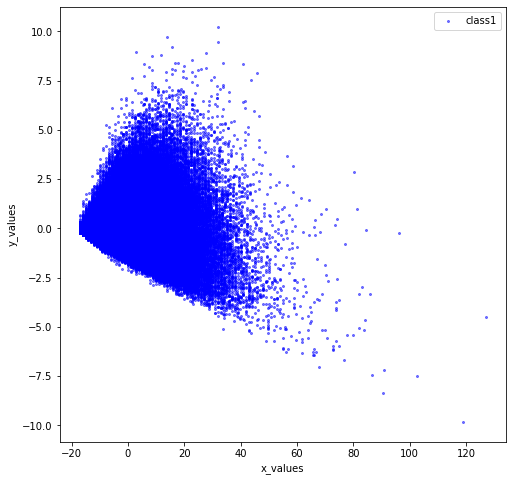

In [51]:
tocluster = pd.DataFrame(ps[[0,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[0], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

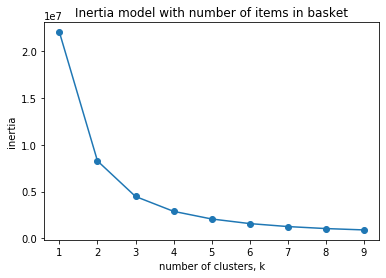

In [52]:
from sklearn.cluster import KMeans
ks = range(1, 10)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(tocluster)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o')
plt.title('Inertia model with number of items in basket')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

According to the graph, we can have three or four cluster model.

In [53]:
clusterer = KMeans(n_clusters=4,random_state=55).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ 0.16953286  0.11890203]
 [-9.41829446 -0.11418373]
 [26.30634093 -0.46205139]
 [10.67994248  0.11950817]]


['blue', 'green', 'blue', 'blue', 'blue', 'blue', 'green', 'orange', 'green', 'purple']


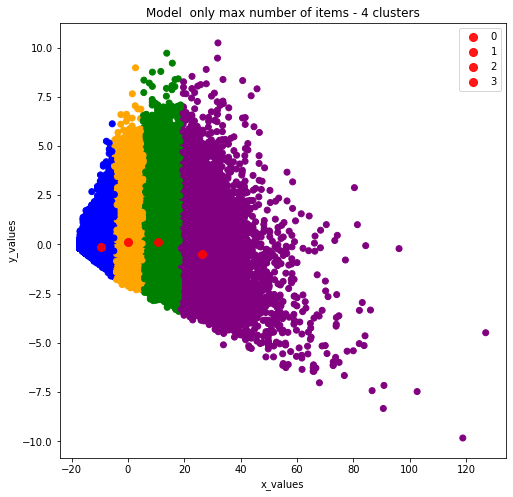

In [54]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.title('Model  only max number of items - 4 clusters')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [55]:
# model with three clusters
clusterer = KMeans(n_clusters=3,random_state=55).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[ 3.4307044   0.14287989]
 [-8.32889045 -0.08162686]
 [19.45047413 -0.15919277]]


['blue', 'purple', 'blue', 'blue', 'blue', 'blue', 'orange', 'orange', 'purple', 'purple']


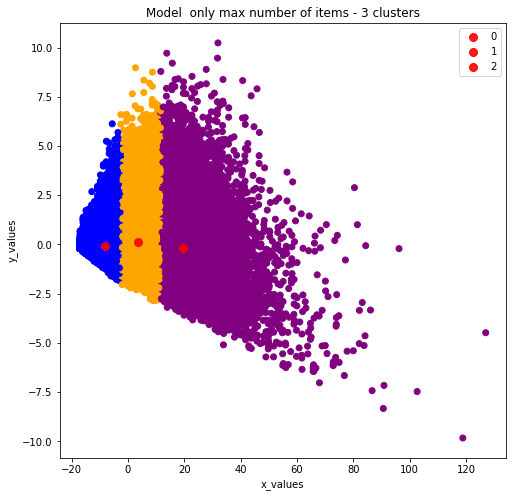

In [56]:
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[0],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.title('Model  only max number of items - 3 clusters')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

## DBScan

In [0]:
# DBScan
from sklearn.cluster import DBSCAN
dbscan = DBSCAN(eps=0.22, leaf_size=30)

In [58]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)
ps = pd.DataFrame(pca_samples)
ps.head()
dbscan.fit(ps)

DBSCAN(algorithm='auto', eps=0.22, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [60]:
centers = list(set(dbscan.labels_))
centers

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, -1]

In [0]:
cust_prod['cluster'] = dbscan.labels_

In [0]:
cust_prod['cluster'] +=1

['blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'orange', 'blue']


No handles with labels found to put in legend.


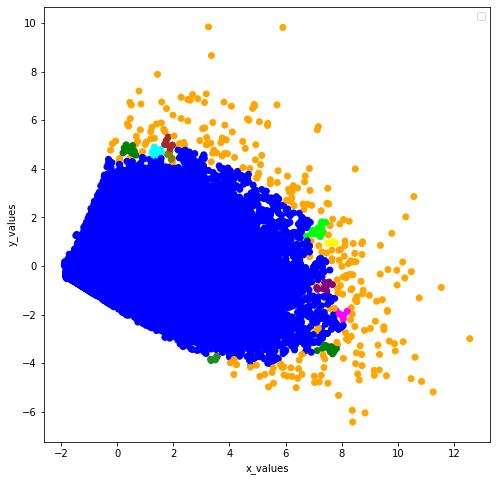

In [63]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

c_preds = dbscan.labels_ + 1
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green','yellow','magenta', 'brown', 
          'green', 'olive', 'cyan', 'forestgreen', 'lime']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(ps[0],ps[1],  color = colored)
#for ci,c in enumerate(centers):
#    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()